# Analysis for jet images

Description

## Set-up

### Loading data

In this section we load all the data that we will need in the analysis. I advise you to comment out all of those that you don't need to save memory. Note that the .pkl-files loaded here are those created in the processing jupyter notebook.

In [42]:
import os
import pandas as pd

save_dir = "plotOutput" # Change this to the path to wherever you want to save the figures
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# =========== Images + jet variables ===========
# Complete DataFrame (image and all jet variables) for only signal jets
df_complete_signal = pd.read_pickle('/Users/nallenallis/Documents/LTH/Exjobb/data/jet images/jet_images_LAGAN_complete_signal.pkl') 

# Complete DataFrame (image and all jet variables) for only background jets
df_complete_bg = pd.read_pickle('/Users/nallenallis/Documents/LTH/Exjobb/data/jet images/jet_images_LAGAN_complete_bg.pkl') 
df_complete_bg_test = pd.read_pickle('/Users/nallenallis/Documents/LTH/Exjobb/data/jet images/jet_images_LAGAN_complete_bg_test.pkl')

# =========== Images ===========
# Only jet images for signal jets
df_signal = pd.read_pickle('/Users/nallenallis/Documents/LTH/Exjobb/data/jet images/images/jet_images_LAGAN_images_signal.pkl') 

# Only jet images for background jets
df_bg = pd.read_pickle('/Users/nallenallis/Documents/LTH/Exjobb/data/jet images/images/jet_images_LAGAN_images_bg.pkl') 
df_bg_test = pd.read_pickle('/Users/nallenallis/Documents/LTH/Exjobb/data/jet images/images/jet_images_LAGAN_images_bg_test.pkl')

# =========== From network ===========
#path_output = '/Users/nallenallis/Documents/LTH/Exjobb/Results/LAGAN/bg_all_img_625-300-100-300-625/val_bg/bg_all_img_625-300-100-300-625_output.pkl'
#path_output = '/Users/nallenallis/Documents/LTH/Exjobb/Results/LAGAN/bg_all_img_625-625-625-625-625/val_bg/bg_all_img_625-625-625-625-625_output.pkl'
#path_output = '/Users/nallenallis/Documents/LTH/Exjobb/Results/LAGAN/bg_all_img_625-625-625-625-625/val_signal/bg_all_img_625-625-625-625-625_output_signal.pkl'
#path_output = '/Users/nallenallis/Documents/LTH/Exjobb/Results/LAGAN/bg_all_img_625-300-100-300-625/val_signal/bg_all_img_625-300-100-300-625_output_signal.pkl'
#df_output = pd.read_pickle(path_output)

df_bg_test_preds = pd.read_pickle('/Users/nallenallis/Documents/LTH/Exjobb/Results/LAGAN/bg_all_img_625-300-100-300-625/bg_all_img_625-300-100-300-625_bg_test_preds.pkl')
df_signal_test_preds = pd.read_pickle('/Users/nallenallis/Documents/LTH/Exjobb/Results/LAGAN/bg_all_img_625-300-100-300-625/bg_all_img_625-300-100-300-625_signal_test_preds.pkl')


### Defining functions and importing libraries

In this section we define functions that are used later on as well as import the libraries needed in future sections.

In [126]:
import matplotlib.pyplot as plt
from scipy import stats

def discrete_mass(jet_image):
    '''
    Calculates the jet mass from a pixelated jet image
    Args:
    -----
        jet_image: numpy ndarray of dim (1, 25, 25)
    Returns:
    --------
        M: float, jet mass
    '''
    Px = np.sum(jet_image * np.cos(phi), axis=(0, 1))
    Py = np.sum(jet_image * np.sin(phi), axis=(0, 1))

    Pz = np.sum(jet_image * np.sinh(eta), axis=(0, 1))
    E = np.sum(jet_image * np.cosh(eta), axis=(0, 1))

    PT2 = np.square(Px) + np.square(Py)
    M2 = np.square(E) - (PT2 + np.square(Pz))
    M = np.sqrt(M2)
    return M

def discrete_pt(jet_image):
    '''
    Calculates the jet transverse momentum from a pixelated jet image
    Args:
    -----
        jet_image: numpy ndarray of dim (1, 25, 25)
    Returns:
    --------
        float, jet transverse momentum
    '''
    Px = np.sum(jet_image * np.cos(phi), axis=(0, 1))
    Py = np.sum(jet_image * np.sin(phi), axis=(0, 1))
    return np.sqrt(np.square(Px) + np.square(Py))

def crop_mass_pt(m,pt):
    '''
    Removes events from distributions that have mass and transverse momentum outside the range
    Args:
    -----
        m: numpy ndarray of mass distribution
        pt: numpy ndarray of transverse momentum distribution
    Returns:
    --------
        m_new: numpy ndarray of new mass distribution
        pt_new: numpy ndarray of new transverse momentum distribution
        nbr_crop: int, number of events removed
    '''
   # Gets indices of all evets to be removed
    idxs = [i for i, val in enumerate(m>max_m) if val]
    idxs = idxs +[i for i, val in enumerate(m<min_m) if val]
    idxs = idxs + [i for i, val in enumerate(pt>max_pt) if val]
    idxs = idxs + [i for i, val in enumerate(pt<min_pt) if val]

    # Removes index duplicates
    idxs = list(dict.fromkeys(idxs))

    # Removes events and creates new distributions
    m_new = np.delete(m, idxs)
    pt_new = np.delete(pt, idxs)
    nbr_crop = len(idxs)
    
    return m_new, pt_new, nbr_crop


## Analysis

### Calculating m, pt from image

In this section we calculate m and pt directly from the images themselves. We then make distributions of m and pt from the calculations and compare to the jet variable ("original") m and pt distributions.

The code is inspired by https://github.com/hep-lbdl/adversarial-jets/blob/master/analysis/plots.ipynb. First, the eta-phi grid is created. We then loop through each image in the data set and reshape them from 625x1 to 25x25. Then with the functions discrete_pt and discrete_mass defined above we calculate m and pt for each image and save in a vector.

In [3]:
# Eta-phi grid
grid = 0.5 * (np.linspace(-1.25, 1.25, 26)[:-1] + np.linspace(-1.25, 1.25, 26)[1:])
eta = np.tile(grid, (25, 1))
phi = np.tile(grid[::-1].reshape(-1, 1), (1, 25))

In [5]:
# Creating empty array to be filled
N_input_signal = len(df_signal) # Length of 436 333, because it contains half of the events in data set (signal)
N_input_bg = len(df_bg_test) # Length of 43 633, because it only contains the "test data"
N_input_bg_all = len(df_bg) # Length of 436 333, because it contains half of the events in data set (background)
N_output_signal = len(df_signal_test_preds) # Length of 436 333, because it contains half of the events in data set (signal)
N_output_bg = len(df_bg_test_preds) # Length of 43 633, because it only contains the "test data" 

m_input_signal = np.zeros(N_input_signal)
m_input_bg = np.zeros(N_input_bg)
m_input_bg_all = np.zeros(N_input_bg_all)
m_output_signal = np.zeros(N_output_signal)
m_output_bg = np.zeros(N_output_bg)

pt_input_signal = np.zeros(N_input_signal)
pt_input_bg = np.zeros(N_input_bg)
pt_input_bg_all = np.zeros(N_output_bg_all)
pt_output_signal = np.zeros(N_output_signal)
pt_output_bg = np.zeros(N_output_bg)

# Calculating m, pt for input (signal) images
for n in range(N_input_signal):
    jet_image = np.array(df_signal.iloc[n,0:625]) # Input (signal)
    jet_image = jet_image.reshape((25,25))
    pt_input_signal[n] = discrete_pt(jet_image)
    m_input_signal[n] = discrete_mass(jet_image)

# Calculating m, pt for input (background) images (ALL)
for n in range(N_input_bg_all):
    jet_image = np.array(df_bg.iloc[n,0:625]) # Input (background)
    jet_image = jet_image.reshape((25,25))
    pt_input_bg_all[n] = discrete_pt(jet_image)
    m_input_bg_all[n] = discrete_mass(jet_image)
    
# Calculating m, pt for input (background) images (test data)
for n in range(N_input_bg):
    jet_image = np.array(df_bg_test.iloc[n,0:625]) # Input (background)
    jet_image = jet_image.reshape((25,25))
    pt_input_bg[n] = discrete_pt(jet_image)
    m_input_bg[n] = discrete_mass(jet_image)

# Calculating m, pt for output (signal) images
for n in range(N_output_signal):
    jet_image = np.array(df_signal_test_preds.iloc[n,0:625]) # Output
    jet_image = jet_image.reshape((25,25))
    pt_output_signal[n] = discrete_pt(jet_image)
    m_output_signal[n] = discrete_mass(jet_image)
    
# Calculating m, pt for output (background) images
for n in range(N_output_bg):
    jet_image = np.array(df_bg_test_preds.iloc[n,0:625]) # Output
    jet_image = jet_image.reshape((25,25))
    pt_output_bg[n] = discrete_pt(jet_image)
    m_output_bg[n] = discrete_mass(jet_image)

### Comparing distributions (input-output)

After the calculations are done, we compare the input (images from data set) and output distributions (images from network). The network will be trained on background so two comparisons are interesting: input-output for background and input-output for signal. In the background case we expect a better fit between input and output than for signal, since the network is trained on background.  

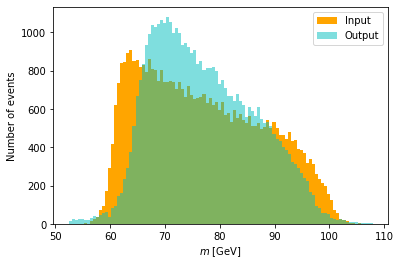

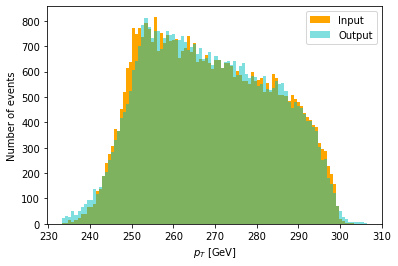

In [20]:
# =========== Input-output distribution comparison (background) ===========
n_bins = 100

save = True

#m
plt.figure()
_,bin_edges,_ = plt.hist(m_input_bg, color='orange', label='Input', alpha=1, bins=n_bins)
plt.hist(m_output_bg, color='c', label='Output', alpha=0.5, bins=bin_edges)
plt.xlabel('$m$ [GeV]')
plt.ylabel('Number of events')
plt.legend()
if save:
    plt.savefig(os.path.join(save_dir,'input_output_dist_m.png'))

#pt
plt.figure()
_,bin_edges,_ = plt.hist(pt_input_bg, color='orange', label='Input', alpha=1, bins=n_bins)
plt.hist(pt_output_bg, color='c', label='Output', alpha=0.5, bins=bin_edges)
plt.xlabel('$p_T$ [GeV]')
plt.ylabel('Number of events')
plt.legend()
if save:
    plt.savefig(os.path.join(save_dir,'input_output_dist_pt.png'))

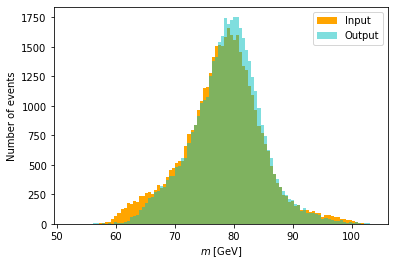

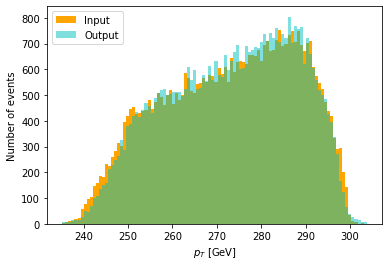

In [136]:
# =========== Input-output distribution comparison (signal) ===========
n_bins = 100

split = round(0.9*len(m_input_signal))s

save = True

#m
plt.figure()
hist_data_in_m, bin_edges, _ = plt.hist(m_input_signal[split:], color='orange', label='Input', alpha=1, bins=n_bins)
hist_data_out_m,_,_ = plt.hist(m_output_signal[split:], color='c', label='Output', alpha=0.5, bins=bin_edges)
plt.xlabel('$m$ [GeV]')
plt.ylabel('Number of events')
plt.legend()
if save:
    plt.savefig(os.path.join(save_dir,'input_output_dist_m_signal.png'))

#pt
plt.figure()
hist_data_in_pt, bin_edges, _ = plt.hist(pt_input_signal[split:], color='orange', label='Input', alpha=1, bins=n_bins)
hist_data_out_pt,_,_ = plt.hist(pt_output_signal[split:], color='c', label='Output', alpha=0.5, bins=bin_edges)
plt.xlabel('$p_T$ [GeV]')
plt.ylabel('Number of events')
plt.legend()
if save:
    plt.savefig(os.path.join(save_dir,'input_output_dist_pt_signal.png'))

### Comparing distributions (input-original)

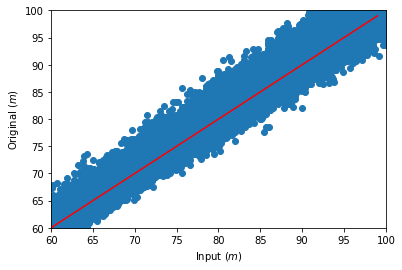

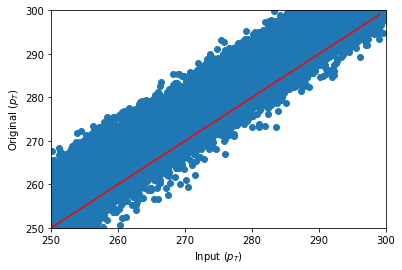

In [43]:
# =========== Input-original comparison (background) ===========
plt.figure(1)
plt.plot(m_input_bg,df_complete_bg_test['m'],'o')
plt.plot(range(60,100),range(60,100),'r')
plt.xlim([60, 100])
plt.ylim([60, 100])
plt.xlabel('Input ($m$)')
plt.ylabel('Original ($m$)')
plt.show()

plt.figure(2)
plt.plot(pt_input_bg,df_complete_bg_test['pt'],'o')
plt.plot(range(250,300),range(250,300),'r')
plt.xlim([250, 300])
plt.ylim([250, 300])
plt.xlabel('Input ($p_T$)')
plt.ylabel('Original ($p_T$)')
plt.show()

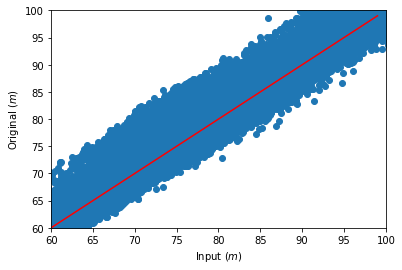

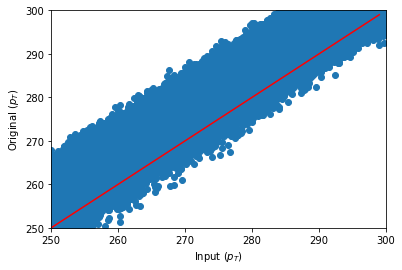

In [36]:
# =========== Input-original comparison (signal) ===========
plt.figure(1)
plt.plot(m_input_signal,df_complete_signal['m'],'o')
plt.plot(range(60,100),range(60,100),'r')
plt.xlim([60, 100])
plt.ylim([60, 100])
plt.xlabel('Input ($m$)')
plt.ylabel('Original ($m$)')
plt.show()

plt.figure(2)
plt.plot(pt_input_signal,df_complete_signal['pt'],'o')
plt.plot(range(250,300),range(250,300),'r')
plt.xlim([250, 300])
plt.ylim([250, 300])
plt.xlabel('Input ($p_T$)')
plt.ylabel('Original ($p_T$)')
plt.show()

Now we want to compare the original distribution (from jet variables) and the image distributions. We first compare signal distributions and then background distributions.

The number of events removed when cropping: 34348


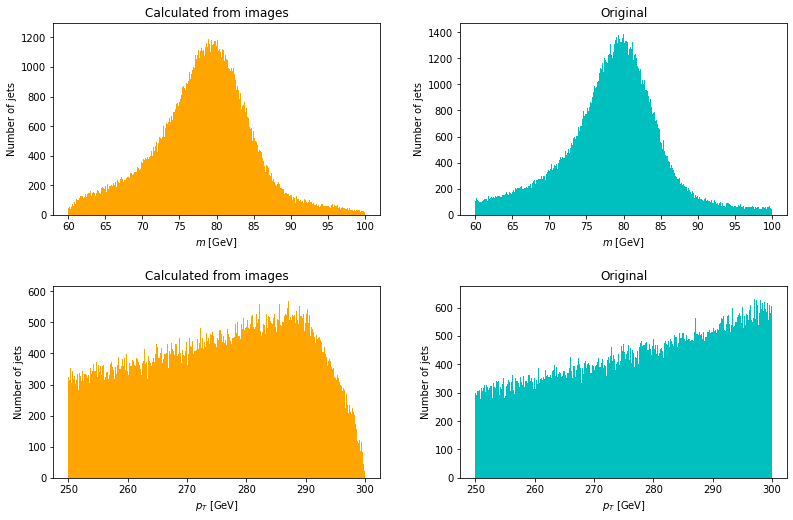

In [128]:
# =========== Input-original distribution comparison (signal) ===========

n_bins = 1000
x_labels = ['$m$ [GeV]','$m$ [GeV]','$p_T$ [GeV]','$p_T$ [GeV]']
titles = ['Calculated from images','Original']

figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
figure.tight_layout(pad=5)

m_crop, p_crop, nbr_crop = crop_mass_pt(m_input_signal,pt_input_signal)
print('The number of events removed when cropping:', nbr_crop)

# =========== m ===========
_,bin_edges,_ = axes[0,0].hist(m_crop, color='orange', bins=n_bins)
axes[0,1].hist(df_complete_signal['m'], color='c', bins=bin_edges)

# =========== pt ===========
_,bin_edges,_ = axes[1,0].hist(p_crop, color='orange', bins=n_bins)
axes[1,1].hist(df_complete_signal['pt'], color='c', bins=bin_edges)

# Adding labels and titles to each subplot
axes = axes.ravel()
for idx,ax in enumerate(axes):
    ax.set_xlabel(x_labels[idx])
    ax.set_title(titles[idx%2])
    ax.set_ylabel('Number of jets')
    
# Saving
save = True
if save:
    plt.savefig(os.path.join(save_dir,'input_original_dist_mpt_signal.png'))

The number of events removed when cropping: 54178


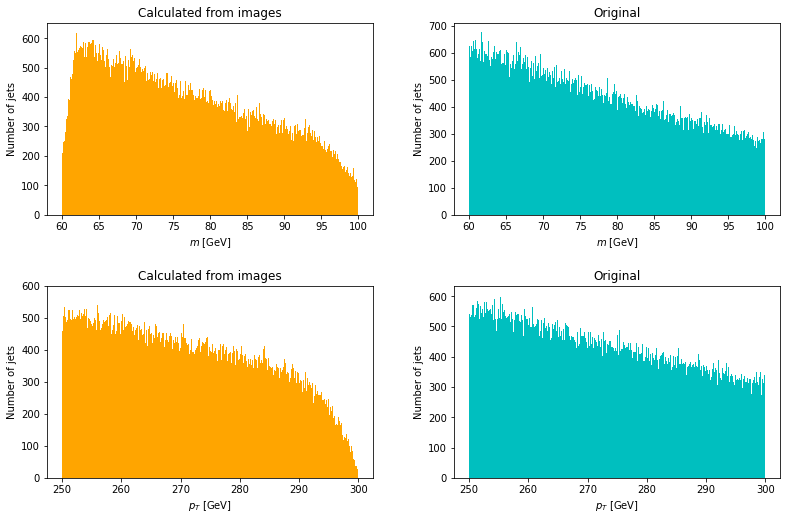

In [127]:
# =========== Input-original distribution comparison (background) ===========

n_bins = 1000
x_labels = ['$m$ [GeV]','$m$ [GeV]','$p_T$ [GeV]','$p_T$ [GeV]']
titles = ['Calculated from images','Original']

figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
figure.tight_layout(pad=5)

m_crop, p_crop, nbr_crop = crop_mass_pt(m_input_bg_all,pt_input_bg_all)
print('The number of events removed when cropping:', nbr_crop)

# =========== m ===========
_,bin_edges,_= axes[0,0].hist(m_crop, color='orange', bins=n_bins)
axes[0,1].hist(df_complete_bg['m'], color='c', bins=bin_edges)

# =========== pt ===========
_,bin_edges,_= axes[1,0].hist(p_crop, color='orange', bins=n_bins)
axes[1,1].hist(df_complete_bg['pt'], color='c', bins=bin_edges)

# Adding labels and titles to each subplot
axes = axes.ravel()
for idx,ax in enumerate(axes):
    ax.set_xlabel(x_labels[idx])
    ax.set_title(titles[idx%2])
    ax.set_ylabel('Number of jets')
    # Optional: Cropping
    #if x_labels[idx] == '$m$ [GeV]':
    #    ax.set_xlim([60,100]) # Cropping, since 60 GeV < m < 100 GeV
    #else:
    #    ax.set_xlim([250,300]) # Cropping, since 250 GeV < pt < 300 GeV

# Saving
save = True
if save:
    plt.savefig(os.path.join(save_dir,'input_original_dist_mpt_bg.png'))

### Residuals

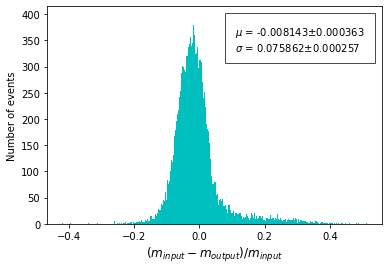

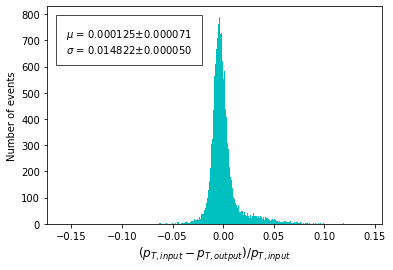

In [65]:
# =========== Input-output distribution comparison (background) ===========

save = True

# Calculating the residuals
N = len(m_input_bg)
residuals = np.zeros([N,2])
residuals[:,0] = (m_input_bg-m_output_bg)/m_input_bg
residuals[:,1] = (pt_input_bg-pt_output_bg)/pt_input_bg

std = np.zeros(2)
std_err = np.zeros(2)
mean = np.zeros(2)
sem = np.zeros(2)

for i in range(2):
    std[i] = np.std(residuals[:, i])
    std_err[i] = np.nanstd(residuals[:, i], axis=None, ddof=0) / np.sqrt(2 * len(residuals[:, i])) #From package, couldn't import
    #std_err[i] = utils.std_error(residuals[:, i]) #From Eric Wulffs TLA_analysis
    mean[i] = np.nanmean(residuals[:, i])
    sem[i] = stats.sem(residuals[:, i], nan_policy='omit')

# Plotting
n_bins = 1000

plt.figure()
plt.hist(residuals[:,0], color='c', bins=n_bins)
plt.xlabel('$(m_{input}-m_{output})/m_{input}$', fontsize=12)
plt.ylabel('Number of events')
plt.text(0.11,330, '$\mu$ = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean[0], sem[0], std[0], std_err[0]), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10})
if save:
    plt.savefig(os.path.join(save_dir,'residual_input_output_bg_m.png'))

plt.figure()
plt.hist(residuals[:,1], color='c', bins=n_bins)
plt.xlabel('$(p_{T,input}-p_{T,output})/p_{T,input}$', fontsize=12)
plt.ylabel('Number of events')
plt.text(-0.155,650, '$\mu$ = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean[1], sem[1], std[1], std_err[1]), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10})
if save:
    plt.savefig(os.path.join(save_dir,'residual_input_output_bg_pt.png'))
    

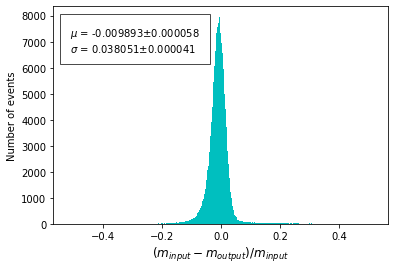

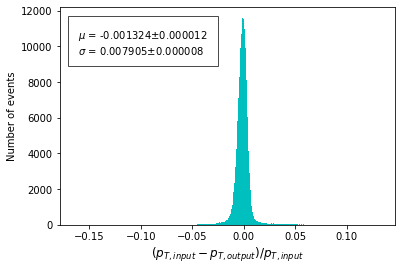

In [68]:
# =========== Input-output distribution comparison (signal) ===========

save = True

# Calculating the residuals
N = len(m_input_signal)
residuals = np.zeros([N,2])
residuals[:,0] = (m_input_signal-m_output_signal)/m_input_signal
residuals[:,1] = (pt_input_signal-pt_output_signal)/pt_input_signal

std = np.zeros(2)
std_err = np.zeros(2)
mean = np.zeros(2)
sem = np.zeros(2)

# Adding errors
for i in range(2):
    std[i] = np.std(residuals[:, i])
    std_err[i] = np.nanstd(residuals[:, i], axis=None, ddof=0) / np.sqrt(2 * len(residuals[:, i])) #From package, couldn't import
    #std_err[i] = utils.std_error(residuals[:, i]) #From Eric Wulffs TLA_analysis
    mean[i] = np.nanmean(residuals[:, i])
    sem[i] = stats.sem(residuals[:, i], nan_policy='omit')

# Plotting
n_bins = 1000

plt.figure()
plt.hist(residuals[:,0], color='c', bins=n_bins)
plt.xlabel('$(m_{input}-m_{output})/m_{input}$', fontsize=12)
plt.ylabel('Number of events')
plt.text(-0.51,6600, '$\mu$ = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean[0], sem[0], std[0], std_err[0]), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10})
if save:
    plt.savefig(os.path.join(save_dir,'residual_input_output_bg_m_signal.png'))

plt.figure()
plt.hist(residuals[:,1], color='c', bins=n_bins)
plt.xlabel('$(p_{T,input}-p_{T,output})/p_{T,input}$', fontsize=12)
plt.ylabel('Number of events')
plt.text(-0.161,9550, '$\mu$ = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean[1], sem[1], std[1], std_err[1]), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10})
if save:
    plt.savefig(os.path.join(save_dir,'residual_input_output_bg_pt_signal.png'))

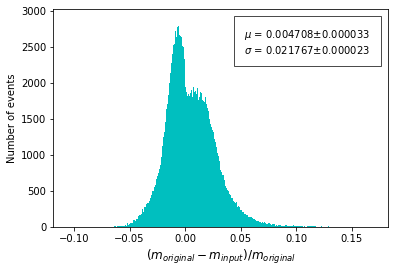

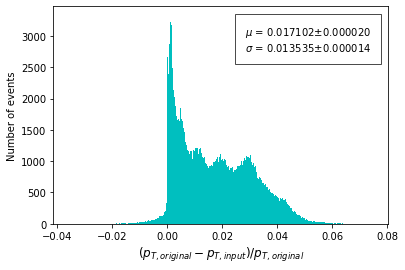

In [69]:
# =========== Input-original distribution comparison (signal) ===========

save = True

# Calculating the residuals
# Calculating the residuals
N = len(df_complete_signal)
residuals = np.zeros([N,2])
residuals[:,0] = (df_complete_signal['m']-m_input_signal)/df_complete_signal['m']
residuals[:,1] = (df_complete_signal['pt']-pt_input_signal)/df_complete_signal['pt']

std = np.zeros(2)
std_err = np.zeros(2)
mean = np.zeros(2)
sem = np.zeros(2)

for i in range(2):
    std[i] = np.std(residuals[:, i])
    std_err[i] = np.nanstd(residuals[:, i], axis=None, ddof=0) / np.sqrt(2 * len(residuals[:, i])) #From package, couldn't import
    #std_err[i] = utils.std_error(residuals[:, i]) #From Eric Wulffs TLA_analysis
    mean[i] = np.nanmean(residuals[:, i])
    sem[i] = stats.sem(residuals[:, i], nan_policy='omit')

# Plotting
n_bins = 1000

n_hist_data, bin_edges, _ = plt.hist(residuals[:,0], color='c', bins=n_bins)
plt.xlabel('$(m_{original}-m_{input})/m_{original}$', fontsize=12)
plt.ylabel('Number of events')
plt.text(0.0535,2400, '$\mu$ = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean[0], sem[0], std[0], std_err[0]), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10})
if save:
    plt.savefig(os.path.join(save_dir,'residual_input_original_signal_m.png'))

plt.figure()
n_hist_data, bin_edges, _ = plt.hist(residuals[:,1], color='c', bins=n_bins)
plt.xlabel('$(p_{T,original}-p_{T,input})/p_{T,original}$', fontsize=12)
plt.ylabel('Number of events')
plt.text(0.0283,2750, '$\mu$ = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean[1], sem[1], std[1], std_err[1]), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10})
if save:
    plt.savefig(os.path.join(save_dir,'residual_input_original_signal_pt.png'))

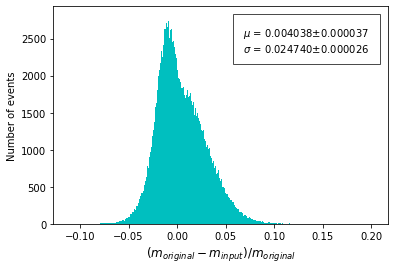

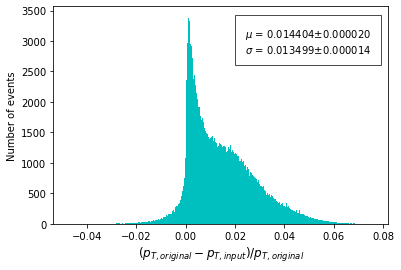

In [70]:
# =========== Input-original distribution comparison (background) ===========

save = True

# Calculating the residuals
# Calculating the residuals
N = len(df_complete_bg)
residuals = np.zeros([N,2])
residuals[:,0] = (df_complete_bg['m']-m_input_bg_all)/df_complete_bg['m']
residuals[:,1] = (df_complete_bg['pt']-pt_input_bg_all)/df_complete_bg['pt']

std = np.zeros(2)
std_err = np.zeros(2)
mean = np.zeros(2)
sem = np.zeros(2)

for i in range(2):
    std[i] = np.std(residuals[:, i])
    std_err[i] = np.nanstd(residuals[:, i], axis=None, ddof=0) / np.sqrt(2 * len(residuals[:, i])) #From package, couldn't import
    #std_err[i] = utils.std_error(residuals[:, i]) #From Eric Wulffs TLA_analysis
    mean[i] = np.nanmean(residuals[:, i])
    sem[i] = stats.sem(residuals[:, i], nan_policy='omit')

# Plotting
n_bins = 1000

n_hist_data, bin_edges, _ = plt.hist(residuals[:,0], color='c', bins=n_bins)
plt.xlabel('$(m_{original}-m_{input})/m_{original}$', fontsize=12)
plt.ylabel('Number of events')
plt.text(0.068,2315, '$\mu$ = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean[0], sem[0], std[0], std_err[0]), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10})
if save:
    plt.savefig(os.path.join(save_dir,'residual_input_original_bg_m.png'))

plt.figure()
n_hist_data, bin_edges, _ = plt.hist(residuals[:,1], color='c', bins=n_bins)
plt.xlabel('$(p_{T,original}-p_{T,input})/p_{T,original}$', fontsize=12)
plt.ylabel('Number of events')
plt.text(0.0240,2798, '$\mu$ = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean[1], sem[1], std[1], std_err[1]), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10})
if save:
    plt.savefig(os.path.join(save_dir,'residual_input_original_bgl_pt.png'))

### Average image

What does the average image look like for signal and background? Let's average them together.

In [60]:
average_signal = np.average(df_signal, axis=0)
average_signal = average_signal.reshape((25,25))

average_bg = np.average(df_bg, axis=0)
average_bg = average_bg.reshape((25,25))

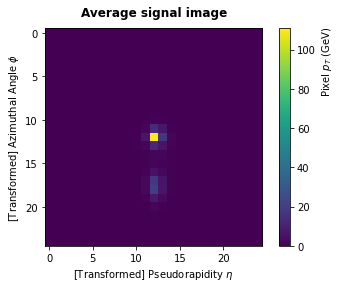

NameError: name 'cmap' is not defined

<Figure size 432x288 with 0 Axes>

In [61]:
import copy
save = True

# Average signal jet image plot
plt.figure(1)
im = plt.imshow(average_signal)
cbar = plt.colorbar(im)
cbar.set_label(r'Pixel $p_T$ (GeV)', y=0.85)
plt.title(f"Average signal image", fontweight="bold",pad=12)
plt.xlabel('[Transformed] Pseudorapidity $\eta$')
plt.ylabel('[Transformed] Azimuthal Angle $\phi$')
if save:
        plt.savefig(os.path.join(save_dir,'average_signal.png'))
plt.show()

# Average background jet image plot
plt.figure(1)
im = plt.imshow(average_bg)
cbar = plt.colorbar(im)
cbar.set_label(r'Pixel $p_T$ (GeV)', y=0.85)
plt.title(f"Average background image", fontweight="bold", pad=12)
plt.xlabel('[Transformed] Pseudorapidity $\eta$')
plt.ylabel('[Transformed] Azimuthal Angle $\phi$')
if save:
        plt.savefig(os.path.join(save_dir,'average_background.png'))
plt.show()

In [ ]:
import matplotlib.pyplot as plt

save = True

N = [37, 1000, 1337]

for n in range(len(N))
    image_output = np.array(pred_df.iloc[n,0:625])
    image_output = image_output.reshape((25,25))

    image_input = np.array(data_df.iloc[n,0:625])
    image_input = image_input.reshape((25,25))

    diff = image_output-image_input

    plt.figure(1)
    plt.imshow(image_input)
    cbar = plt.colorbar(im)
    cbar.set_label(r'Pixel $p_T$ (GeV)', y=0.85)
    plt.title(f"Jet image #{n} (Input)")
    plt.xlabel('[Transformed] Pseudorapidity $\eta$')
    plt.ylabel('[Transformed] Azimuthal Angle $\phi$')
    if save:
            plt.savefig(os.path.join(save_dir,f"Jet image #{n} (Input)"+'.png'))
    plt.show()

    plt.figure(2)
    plt.imshow(image_output)
    cbar = plt.colorbar(im)
    cbar.set_label(r'Pixel $p_T$ (GeV)', y=0.85)
    plt.title(f"Jet image #{n} (Output)")
    plt.xlabel('[Transformed] Pseudorapidity $\eta$')
    plt.ylabel('[Transformed] Azimuthal Angle $\phi$')
    if save:
            plt.savefig(os.path.join(save_dir,f"Jet image #{n} (Output)"+'.png'))
    plt.show()

    plt.figure(3)
    plt.imshow(diff)
    plt.colorbar()
    plt.title(f"Jet image #{n} (Difference)")
    plt.xlabel('[Transformed] Pseudorapidity $\eta$')
    plt.ylabel('[Transformed] Azimuthal Angle $\phi$')
    if save:
            plt.savefig(os.path.join(save_dir,f"Jet image #{n} (Difference)"+'.png'))
    plt.show() 